In [1]:
%matplotlib inline 

import numpy as np
import scipy
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
from mpl_toolkits.mplot3d import Axes3D #3D plotting
import datetime as dt # module for manipulating dates and times

import requests 
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import binom
from scipy.optimize import minimize_scalar
from __future__ import division
import re
from StringIO import StringIO
from zipfile import ZipFile 
from pandas import read_csv
from urllib import urlopen
import urllib2
import json

import sklearn
import sklearn.preprocessing
import sklearn.datasets

# Gaussian Shocks

### LMSR ACCORDING TO Brahma et al.

In [2]:
# LMSR Implementation Das Interpretation
# according to http://www.cse.wustl.edu/~mithunchakraborty/papers/AAAI15poster_final.pdf
def runlmsr_gaussian(iterations, trialnumber, MMb, traderAlphaExponential, shock_prob, shock_sd):
    trial_1 = np.zeros(trialnumber)
    trial_2 = np.zeros(trialnumber)

    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMquantity_1[0] = 0
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMquantity_2[0] = 0
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        MMpayment[0] = 0

        for time in np.arange(1,iterations,1):
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            if traderValue > MMprice_1[time - 1]:
                quantityEquivalentprice = MMb*(np.log((traderValue*(np.exp(currentquantity_2/MMb))/100) / \
                                                      (1-traderValue/100)))-currentquantity_1
                # error checking
                if quantityEquivalentprice < 0:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2
                    raise NameError('Problem with Quantity Calculation')
                quantityTrader_1 = min(quantityTrader, quantityEquivalentprice)
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityEquivalentprice = MMb*(np.log(((100-traderValue)*(np.exp(currentquantity_1/MMb))/100)/ \
                                                      (1-(100-traderValue)/100)))-currentquantity_2
                # error checking
                if quantityEquivalentprice < 0:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2
                    raise NameError('Problem with Quantity Calculation')
                quantityTrader_2 = min(quantityTrader, quantityEquivalentprice)
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(np.exp(newquantity_1/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            MMprice_2[time] = 100*(np.exp(newquantity_2/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
        trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        trial_2[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
    return trial_1, trial_2, trueValue, MMprice_1

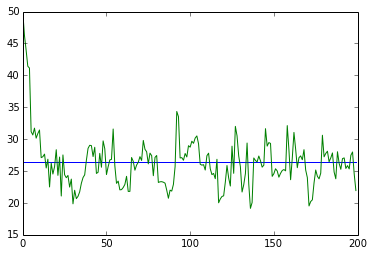

616.387974594
4403.35653299
-8362.58919681


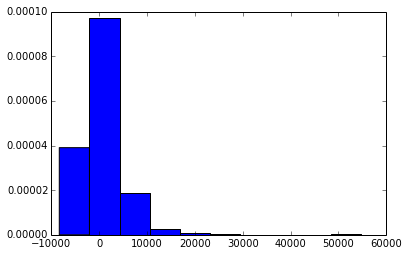

611.4501675
4172.68578691
-8585.17949208


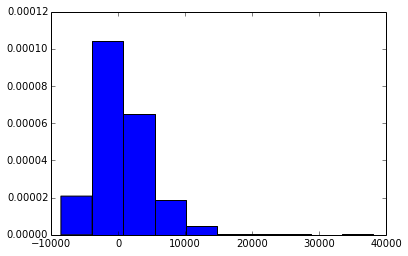

In [3]:
# Baseline Revenue Results 
trial_1, trial_2, trueValue, MMprice_1 = runlmsr_gaussian(200, 1000, 125, 20, 1/100, 5)

# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))
plt.hist(trial_1, normed=1)
plt.show()

#outcome 2 occurs
print(np.average(trial_2))
print(np.std(trial_2))
print(np.min(trial_2))
plt.hist(trial_2, normed=1)
plt.show()

### LMSR TEXTBOOK

In [16]:
# LMSR Implementation Textbook Interpretation
def runlmsr_gaussiantextbook(iterations, trialnumber, MMb, traderAlphaExponential, shock_prob, shockSD):
    trial_1 = np.zeros(trialnumber)
    trial_2 = np.zeros(trialnumber)

    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMquantity_1[0] = 0
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMquantity_2[0] = 0
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        MMpayment[0] = 0

        for time in np.arange(1,iterations,1):
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            if traderValue > MMprice_1[time - 1]:
                quantityTrader_1 = MMb*(np.log((traderValue*(np.exp(currentquantity_2/MMb))/100) / \
                                                      (1-traderValue/100)))-currentquantity_1
                # error checking
                if quantityTrader_1 < 0 and traderValue<90.:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2, quantityTrader_1
                    raise NameError('Problem with Quantity Calculation')
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityTrader_2 = MMb*(np.log(((100-traderValue)*(np.exp(currentquantity_1/MMb))/100)/ \
                                                      (1-(100-traderValue)/100)))-currentquantity_2
                # error checking
                if quantityTrader_2 < 0 and traderValue<90.:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2, quantityTrader_2
                    raise NameError('Problem with Quantity Calculation')
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(np.exp(newquantity_1/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            MMprice_2[time] = 100*(np.exp(newquantity_2/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
        trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        trial_2[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
    return trial_1, trial_2, trueValue, MMprice_1


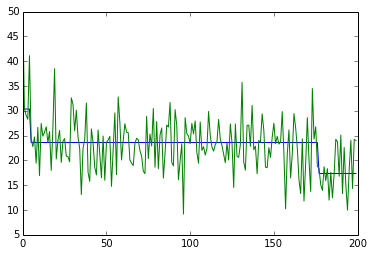

622.340153852
4398.9004899
-7764.15342165


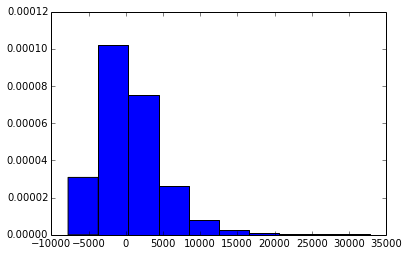

691.036899571
4286.83792501
-8201.08041409


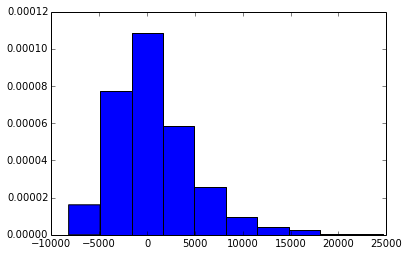

In [17]:
# Baseline Revenue Results 
trial_1, trial_2, trueValue, MMprice_1 = runlmsr_gaussiantextbook(200, 1000, 125, 20, 1/100, 5)
# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))
plt.hist(trial_1, normed=1)
plt.show()

#outcome 2 occurs
print(np.average(trial_2))
print(np.std(trial_2))
print(np.min(trial_2))
plt.hist(trial_2, normed=1)
plt.show()


### Liquidity Sensitive LMSR Implementation Das Interpretation


In [18]:
#Liquidity Sensitive LMSR Implementation Das Interpretation

def runlslmsr_gaussian(iterations, trialnumber, traderAlphaExponential, shock_prob, shock_sd, alpha, initialsubsidy):
    trial_1 = np.zeros(trialnumber)
    trial_2 = np.zeros(trialnumber)

    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMquantity_1[0] = initialsubsidy
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMquantity_2[0] = initialsubsidy
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        MMpayment[0] = 0

        for time in np.arange(1,iterations,1):
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            MMb = alpha*(currentquantity_1 + currentquantity_2)
            
            if traderValue > MMprice_1[time - 1]:
                quantityTrader_1 = quantityTrader
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityTrader_2 = quantityTrader
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
                
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_2*(np.exp(newquantity_1/MMb)-np.exp(newquantity_2/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            MMprice_2[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_1*(np.exp(newquantity_2/MMb)-np.exp(newquantity_1/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
        trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        trial_2[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
    return trial_1, trial_2, trueValue, MMprice_1

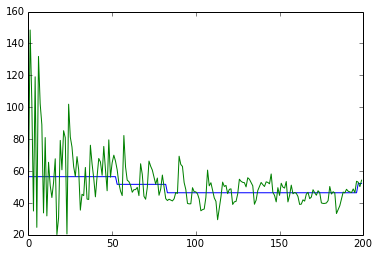

3932.88351092
7386.47803847
-9625.13629838


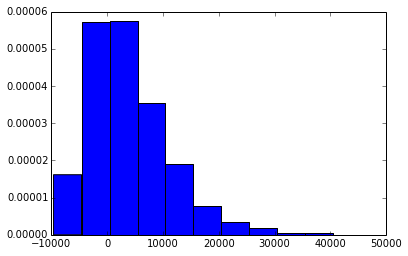

139.242147638
6391.01178353
-10252.4042038


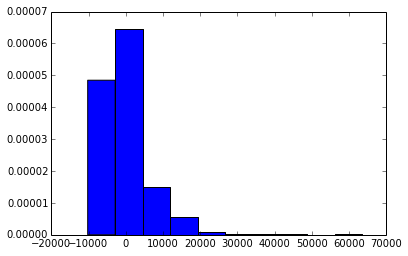

In [21]:
# Baseline Revenue Results 
trial_1, trial_2, trueValue, MMprice_1 = runlslmsr_gaussian(200, 1000, 20, 1/100, 5, 0.05, 10)
# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))
plt.hist(trial_1, normed=1)
plt.show()

#outcome 2 occurs
print(np.average(trial_2))
print(np.std(trial_2))
print(np.min(trial_2))
plt.hist(trial_2, normed=1)
plt.show()


### Liquidity sensitive - trying an optimzer to solve for myopic trader

In [22]:
#Liquidity Sensitive LMSR Implementation Das Interpretation

def runlslmsr_gaussianmyopic(iterations, trialnumber, traderAlphaExponential, shock_prob, shock_sd, alpha, initialsubsidy):
    trial_1 = np.zeros(trialnumber)
    trial_2 = np.zeros(trialnumber)

    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMquantity_1[0] = initialsubsidy
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMquantity_2[0] = initialsubsidy
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        MMpayment[0] = 0

        for time in np.arange(1,iterations,1):
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            MMb = alpha*(currentquantity_1 + currentquantity_2)
            
            if traderValue > MMprice_1[time - 1]:
                f = lambda q: alpha*np.log(np.exp(q/MMb) + \
                                           np.exp(currentquantity_2/MMb)) + (currentquantity_2*(np.exp(q/MMb) - \
                                           np.exp(currentquantity_2/MMb))) / ((q+currentquantity_2)*(np.exp(q/MMb) + \
                                           np.exp(currentquantity_2/MMb)))
                res = minimize_scalar(f, method='brent')
                if res.x > 0 and res.success == 1:
                    quantityTrader_1 = min(quantityTrader, res.x)
                else:
                    quantityTrader_1 = quantityTrader
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                f = lambda q: alpha*np.log(np.exp(q/MMb) + \
                                           np.exp(currentquantity_1/MMb)) + (currentquantity_1*(np.exp(q/MMb) - \
                                           np.exp(currentquantity_1/MMb))) / ((q+currentquantity_1)*(np.exp(q/MMb) + \
                                           np.exp(currentquantity_1/MMb)))
                res = minimize_scalar(f, method='brent')
                if res.x > 0 and res.success == 1:
                    quantityTrader_2 = min(quantityTrader, res.x)
                else:
                    quantityTrader_2 = quantityTrader
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
                
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_2*(np.exp(newquantity_1/MMb)-np.exp(newquantity_2/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            MMprice_2[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_1*(np.exp(newquantity_2/MMb)-np.exp(newquantity_1/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
        trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        trial_2[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
    return trial_1, trial_2, trueValue, MMprice_1

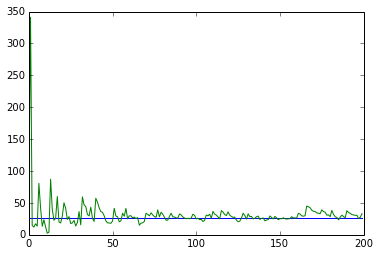

3202.23933868
7497.61004123
-8960.5291038


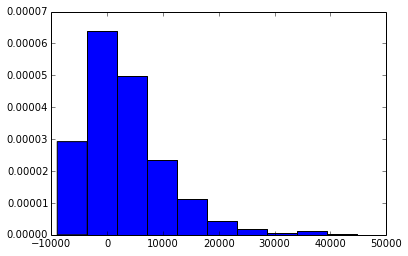

784.75761217
6181.96826297
-10161.9904131


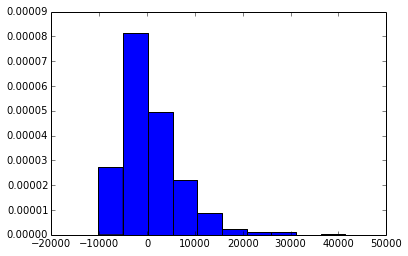

In [23]:
# Baseline Revenue Results 
trial_1, trial_2, trueValue, MMprice_1 = runlslmsr_gaussianmyopic(200, 1000, 20, 1/100, 5, 0.05, 10)
# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))
plt.hist(trial_1, normed=1)
plt.show()

#outcome 2 occurs
print(np.average(trial_2))
print(np.std(trial_2))
print(np.min(trial_2))
plt.hist(trial_2, normed=1)
plt.show()


## Our LMSR model

## Outline for BMM

In [ ]:
''' 
# BMM implementation
iterations = 200
trial = np.zeros(1000)

for i in np.arange(0,100,1):
    # Initialize Market Model
    initialValue = np.random.normal(50,12)
    if initialValue < 0:
        initialValue = 0
    if initialValue > 100:
        initialValue = 100

    # shock values
    shock_prob= 1/100
    shockSD = 5
    # true asset value
    trueValue = np.zeros(iterations)
    trueValue[0] = initialValue

    # Initial Trade Values
    traderAlphaExponential = 20
    traderSD = 5
    traderValueAll = np.zeros(iterations)
    traderValueAll[0] = initialValue
    
    #initial MM values
    MMquantity = np.zeros(iterations)
    MMquantity[0] = 0
    MMprice = np.zeros(iterations)
    MMprice[0] = initialvalue
    MMrevenue = np.zeros(iterations)
    MMrevenue[0] = 0
    MMwindow = 5
    MMexpectedvalue = np.zeros(iterations)
    MMexpectedvalue[0] = initialvalue
    MMsdvalue = np.zeros(iterations)
    MMsdvalue[0] = 0
    MMsdvalue[1]
    for time in np.arange(1,iterations,1):
        if np.random.binomial(1,shock_prob) == 1:
            initialValue = initialValue + np.random.normal(0, shockSD)
        trueValue[time] = initialValue
        traderValue = np.random.normal(initialValue, traderSD)
        traderValueAll[time] = traderValue
        if traderValue <= 0:
            traderValue = 0.01
        if traderValue > 100:
            traderValue = 99.99
        quantityTrader = np.random.exponential(traderAlphaExponential)
        if traderValue > MMprice[time - 1]:
            
            A = 
            B = 
            C = 
'''